# Function:  NETD -  Noise Equivelant Temperature Difference 

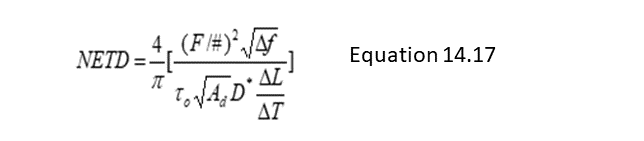

In [1]:
#NETD    Version 20    18-Oct-2022
%matplotlib inline
from ipywidgets import interact, Layout, widgets
import numpy as np
import matplotlib.pyplot as plt

 ## NETD Background etc.

Header = widgets.HTML(value = "<br><p style='font-size:12pt'><b> Wavelenght should correspond to median of band corresponding from the associated calculations</b></p>")
display(Header)

#constants
c=2.9979e8 #m/sec
c1=3.7418e4 #watt-um^4/cm^2
c2=1.4388e4 #um-K
h=6.6e-34 # m2 kg / s  plancks constant
q=1.6e-19 #coulomg charge of e

#primary calculations and plotting
def plot_func(wvl,FNO,Tint,Pitch,PhotoC,DarkC,RFNe,Tran,Temp):
 
    QE=1.0
    
    #planck derivative 
    wvlm = wvl*1e-6
    t1 = np.exp(c2/(wvl*Temp))  #unitless - temporary constant for eqn below
    #print((wvl*Temp),c2,(c2/(wvl*Temp)),'t1=',t1)
    t2= c1/wvl**5
    t3= (1/(t1 - 1))
    M = t2*t3 # Watt/(cm^2 - um) M 5.11  pg126
    L=M/np.pi
    PLDR2 = (L*c2*t1)/(wvl*(Temp**2)*(t1 - 1)) #planck function deriviative Holst yello textbook 3.46 pg55 
    #print('L= ',L, '  PLDR= ', PLDR2)
    
    
    #Noise electrons
    #RFNe = ROIC fixed noise is a given input
    PNe = np.sqrt((PhotoC*Tint)/q)  # Photon Shot Noise
    DNe = np.sqrt((DarkC*Tint)/q)  # Dark Current Noise
    TNe = np.sqrt((DNe**2 + PNe**2 + RFNe**2)) #add noise in quadrature - Dark Noise e + photon/flux noise e + ROIC fixed noise floor
    #print( "ShotNe =" ,"{:.1f}".format(FLNe),"DarkNE - ","{:.1f}".format(DNe), "TotalNe = ","{:.1f}".format(TNe))
    
    #DSTAR calc
    P1 = (PhotoC*Tint)/q  #photocurrent times integration time / q = #photoelectrons
    #print ("photo electrons",P1)
    SNR = P1/TNe #photoelectrons / total noise electrons
    Power = (h*c/wvlm)*(P1/Tint) #energy per photons in on Tint, and divide by integration time for constant flux source
    NEP = Power/SNR
    NEI = TNe/(QE*Tint*(Pitch*1e-4)**2)
    DSTAR2 = (Pitch * 1e-4 * np.sqrt(1/(2*Tint)))/NEP  # cm-Hz^1/2 per Watt  D* eqn 8.24 2nd edition
    print("SNR=", "{:.2e}".format(SNR), "D*=", "{:.2e}".format(DSTAR2),"(cm-Hz^1/2)/W", "NEI=","{:.2e}".format(NEI),"Photon/Sec-cm^2")
        
    #NETD calc
    num =(FNO**2)*np.sqrt(1/(2*Tint))   #numerator
    #den = Tran*Pitch*0.0001*DSTAR*PLDR2  #denominator
    den2 = Tran*Pitch*1e-4*DSTAR2*PLDR2  #denominator
    NETD2 = (4*num)/(np.pi*den2)  #NETD formula 14.17 in 2nd edition
 
    #print('PLDR = ',"{:.3e}".format(PLDR2), 'D* =',"{:.2e}".format(DSTAR2),'NEI=',"{:.2e}".format(NEI))
    print('Noise Equivelant Temperature Difference (NETD) = ',"{:.2f}".format(1000*NETD2),"mK")      

    numpts = 20
    templow = Temp*0.9
    temphigh = Temp*1.1
    step = (temphigh - templow)/numpts
    Templist = np.arange(templow,temphigh,step)
    t1list = []
    t3list = []
    Llist =[]
    PLDRlist = []
    denlist = []
    NETDlist = []
    cnt=0
    for i in Templist:
        t1list.append(np.exp(c2/(wvl*Templist[cnt])))
        #t2= c1/wvl**5
        t3list.append((1/(t1list[cnt] - 1)))
        Llist.append(t3list[cnt]*t2/np.pi)
        PLDRlist.append((Llist[cnt]*c2*t1list[cnt])/(wvl*(Templist[cnt]**2)*(t1list[cnt] - 1)))
        denlist.append(Tran*Pitch*0.0001*DSTAR2*PLDRlist[cnt])
        NETDlist.append((4*num)/(np.pi*denlist[cnt]))
        cnt+=1
    
    #plotting
    plt.style.use('classic')
    plt.figure(figsize=(12,7))
    plt.plot(Templist,NETDlist,'b')
    plt.plot(Templist,NETDlist,'*b')
    plt.title('Noise Equivelant Temperature Difference')
    plt.xticks(np.arange(templow, temphigh, 4*step))
    plt.grid(True)
    plt.xlabel('Temperature Kelvin')
    plt.ylabel('NETD (K)')
    plt.axis([templow,temphigh-step,0.5*min(NETDlist),1.1*max(NETDlist)])
    
    #make a vertical line
    vlinex = np.repeat(Temp, 3)
    vliney = [0,NETD2,10*NETD2]
    plt.plot (vlinex,vliney,'k:', linewidth = 2)
    plt.text(Temp, 0.6*min(NETDlist),"  " + str(int(Temp)) + "K",color='Black')
    #make a horiz line
    hliney = np.repeat(NETD2, 3)
    hlinex = [templow/2,Temp,10*Temp]
    plt.plot (hlinex,hliney,'k:', linewidth = 2)
    plt.text(templow, 1.05*NETD2,"  " + str(int(1000*NETD2)) +"mK",color='Black')
    
# Description width style
style1 = {'description_width': 'initial'} 
        
interact(plot_func, 
         wvl = widgets.FloatText(value=4.0, description = 'Wavelenght (um)',style=style1),
         FNO = widgets.FloatText(value=2.0, description = 'Focal Ratio (f/#)',style=style1),  
         Tint = widgets.FloatText(value=3e-3, description = 'Tint (sec)',style=style1),
         Pitch = widgets.FloatText(value=20, description = 'Pixel Pitch (um))',style=style1),
         PhotoC = widgets.FloatText(value=2.0e-10, description = 'Photo Current (A)',style=style1),
         DarkC = widgets.FloatText(value=2.7e-12, description = 'Dark Current (A)',style=style1),
         RFNe = widgets.FloatText(value=600, description = 'ROIC Fixed Noise electrons (#)',style=style1),
         #DNNe = widgets.FloatText(value=2000, description = 'Downstream Noise electrons (#)',style=style1),
         #QE = widgets.FloatText(value=0.8, description = 'Quantum Efficiency (%)',style=style1),
         #DSTAR = widgets.FloatText(value=5e10, description = 'D*',style=style1),
         #PLDR = widgets.FloatText(value=6.3e-5, description = 'Plank Derivative',style=style1),
         Tran = widgets.FloatText(value=.8, description = 'Transmission',style=style1),
         Temp = widgets.FloatText(value=300, description = 'Temperature (K)',style=style1),
         #Flux = widgets.FloatText(value=1.7e9, description = 'Flux (Ph/sec)',style=style1),
        )


HTML(value="<br><p style='font-size:12pt'><b> Wavelenght should correspond to median of band corresponding fro…

interactive(children=(FloatText(value=4.0, description='Wavelenght (um)', style=DescriptionStyle(description_w…

<function __main__.plot_func(wvl, FNO, Tint, Pitch, PhotoC, DarkC, RFNe, Tran, Temp)>